In [144]:
import networkx as nx
import torch
import numpy as np
from torch import Tensor
import os
import random
from torch_geometric.data import Data
from itertools import combinations
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,  global_mean_pool
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

In [146]:
#load attributes from the whole graph
def get_graph_attributes(graph):
    """Retrieves global graph-level attributes from GraphML metadata."""
    attributes = {
        "edge_crossings": graph.graph.get("edge_crossings", 0),
        "diameter": graph.graph.get("diameter", 0),
        "avg_shortest_path": graph.graph.get("avg_shortest_path", 0),
        "num_components": graph.graph.get("num_components", 0),
        "density": graph.graph.get("density", 0),
        "assortativity": graph.graph.get("assortativity", 0),
    }
    return attributes

def get_node_features(graph):
    """Retrieves node attributes from GraphML."""
    node_features = []
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}

    for node in graph.nodes():
        x_pos = float(graph.nodes[node].get("x_pos", 0))
        y_pos = float(graph.nodes[node].get("y_pos", 0))
        degree = graph.degree[node]
        clustering = float(graph.nodes[node].get("clustering", 0))
        betweenness = float(graph.nodes[node].get("betweenness", 0))
        eigenvector = float(graph.nodes[node].get("eigenvector", 0))
        pagerank = float(graph.nodes[node].get("pagerank", 0))

        node_features.append([x_pos, y_pos, degree, clustering, betweenness, eigenvector, pagerank])

    return torch.tensor(node_features, dtype=torch.float), node_mapping

def networkx_to_pyg_data(graph):
    """Converts a NetworkX graph to a PyTorch Geometric Data object with all features."""
    node_features, node_mapping = get_node_features(graph)
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges()], dtype=torch.long).t().contiguous()
    
    graph_attrs = get_graph_attributes(graph)
    y = torch.tensor([graph_attrs["edge_crossings"]], dtype=torch.float)  # Target variable

    return Data(x=node_features, edge_index=edge_index, y=y)

def load_graphs(folder_path):
    """Loads GraphML files and converts them into PyTorch Geometric dataset."""
    dataset = []
    for file in os.listdir(folder_path):
        if file.endswith(".graphml"):
            file_path = os.path.join(folder_path, file)
            try:
                graph = nx.read_graphml(file_path)
                pyg_data = networkx_to_pyg_data(graph)
                dataset.append(pyg_data)
            except Exception as e:
                print(f"Error loading {file}: {e}")

    random.shuffle(dataset)
    return dataset




# Simple GCN
#### 2 layers
#### Node attributes 
x_pos, y_pos, degree O(n+m) , clustering coefficient, betweenness , eigenvector , pagerank \n
#### Edge 
edge index
#### Objective
number of crossings


In [149]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor) -> Tensor:
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Aggregate node features to graph-level
        return x.squeeze()   # Ensure output shape is [batch_size]

In [151]:
folder_path = r"C:\Users\lucas\Desktop\thesis\code\ThesisLucasdelArco\Data\rome1_processed"
dataset = load_graphs(folder_path)

Training Samples: 328, Validation Samples: 70, Testing Samples: 71
Epoch 0, Train Loss: 19.1974, Val Loss: 19.3096
Epoch 10, Train Loss: 5.7724, Val Loss: 7.6239
Epoch 20, Train Loss: 5.1151, Val Loss: 6.8139
Epoch 30, Train Loss: 4.4448, Val Loss: 5.8989
Epoch 40, Train Loss: 3.8469, Val Loss: 5.2040


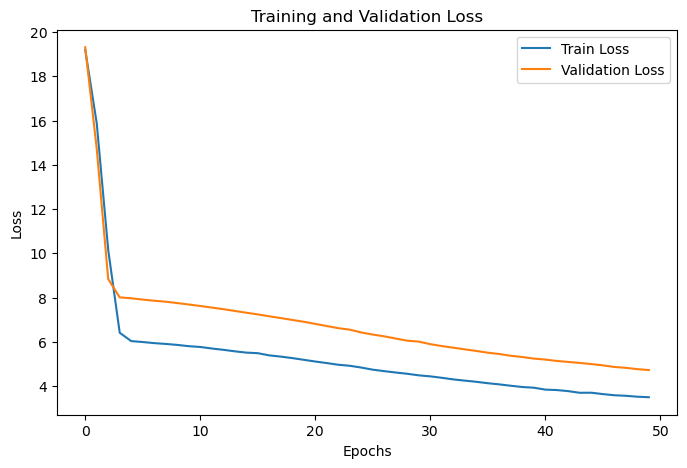

In [152]:
# Split dataset
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(f"Training Samples: {len(train_data)}, Validation Samples: {len(val_data)}, Testing Samples: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Initialize model
num_node_features = dataset[0].x.shape[1]
model = GCN(in_channels=num_node_features, hidden_channels=32, out_channels=1)

# Set optimizer and loss function
learning_rate = 0.001
epochs = 50
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.HuberLoss()

train_losses, val_losses = [], []

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch)  # Pass batch info
        loss = loss_fn(pred, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data in val_loader:
            pred = model(data.x, data.edge_index, data.batch).squeeze()  # Pass batch info
            loss = loss_fn(pred, data.y)
            val_loss += loss.item()


    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


C:\Users\lucas\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R^2 Score: 0.6014, RMSE: 5.9551, ACCURACY: 18.3099


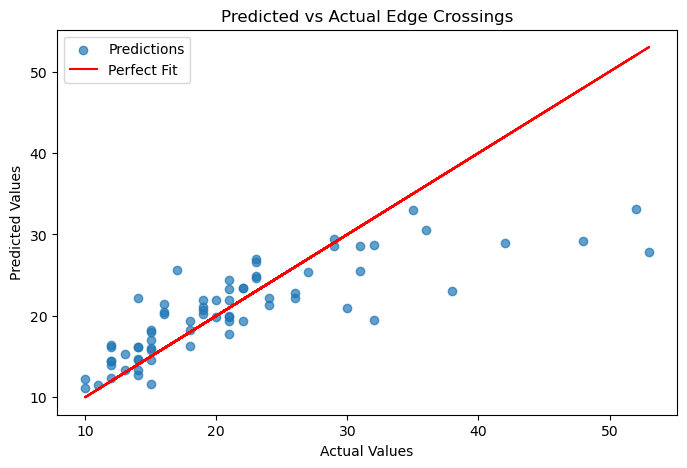

In [159]:

model.eval()
true_values, predicted_values = [], []

with torch.no_grad():
    for data in test_loader:
        pred = model(data.x, data.edge_index, data.batch).squeeze() 
        true_values.extend(data.y.cpu().numpy().flatten().tolist())
        predicted_values.extend(pred.cpu().numpy().flatten().tolist())


# Compute Metrics
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
r2 = r2_score(true_values, predicted_values)
rmse = mean_squared_error(true_values, predicted_values, squared=False)
tolerance = 1
correct_within_tolerance = np.abs(true_values - predicted_values) <= tolerance
accuracy_within_tolerance = np.mean(correct_within_tolerance) * 100
print(f"R^2 Score: {r2:.4f}, RMSE: {rmse:.4f}, ACCURACY: {accuracy_within_tolerance:.4f}")


#make graph
plt.figure(figsize=(8, 5))
plt.scatter(true_values, predicted_values, alpha=0.7, label="Predictions")
plt.plot(true_values, true_values, linestyle="-", color="red", label="Perfect Fit")  # Identity line y=x
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Edge Crossings')
plt.legend()
plt.show()